# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

sys.path.append("..")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'

import nucml.plot.utilities as plot_utils
import nucml.datasets as nuc_data
import nucml.exfor.data_utilities as exfor_utils

In [172]:
sns.set(font_scale=2.5)
sns.set_style("white")

# Setting up the path where our figures will be stored
figure_dir = "Figures/"

**NOTE: WHEN WE TALK ABOUT CROSS SECTIONS WE ARE REFERING TO THE FEATURE "DATA" WHICH IS OUR LABEL**

# Loading the EXFOR Database using NucML

In [3]:
df = nuc_data.load_exfor()
df.MT = df.MT.astype(int)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: False
INFO:root: LOG: False
INFO:root: BASIC: -1
INFO:root: SCALER: STANDARD
INFO:root:Reading data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/EXFOR/CSV_Files\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4255409, 104)
INFO:root:Finished. Resulting dataset has shape (4255409, 104)


In [4]:
df = df[df.Energy <= 2E7]

In [5]:
df = df[df.Energy != 0]

# Example using U235(N,G)

In [50]:
u235_ng = exfor_utils.load_samples(df, 92, 235, 102)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (10872, 104)


In [51]:
u235_ng = np.log10(u235_ng[["Energy", "Data"]])

# Isolation Forest

In [114]:
from sklearn.ensemble import IsolationForest

In [115]:
outliers_fraction = 0.003

In [116]:
u235_ng = u235_ng[u235_ng.Energy < 4]
u235_ng = u235_ng[u235_ng.Energy > 0.5]

In [117]:
iso_forest_fraction = IsolationForest(n_estimators = 200, contamination=outliers_fraction)

In [118]:
iso_forest_fraction.fit(u235_ng[["Data"]])

IsolationForest(contamination=0.003, n_estimators=200)

In [119]:
u235_ng["iso_fraction"] = iso_forest_fraction.predict(u235_ng[["Data"]])

In [120]:
iso_class1 = u235_ng[u235_ng.iso_fraction == 1]
iso_class2 = u235_ng[u235_ng.iso_fraction == -1]

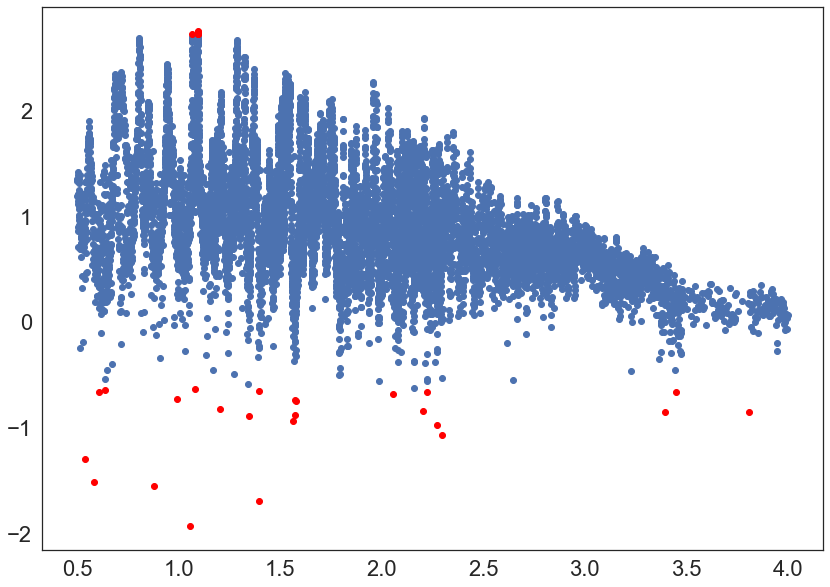

In [121]:
plt.figure(figsize=(14,10))
plt.scatter(iso_class1.Energy, iso_class1.Data)
plt.scatter(iso_class2.Energy, iso_class2.Data, color="red")

In [122]:
from sklearn import svm

In [123]:
svm_outlier_detector = svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)

In [124]:
svm_outlier_detector.fit(u235_ng[["Data"]])

OneClassSVM(gamma=0.1, nu=0.003)

In [125]:
u235_ng["svm"] = svm_outlier_detector.predict(u235_ng[["Data"]])

In [126]:
svm_class1 = u235_ng[u235_ng.svm == 1]
svm_class2 = u235_ng[u235_ng.svm == -1]

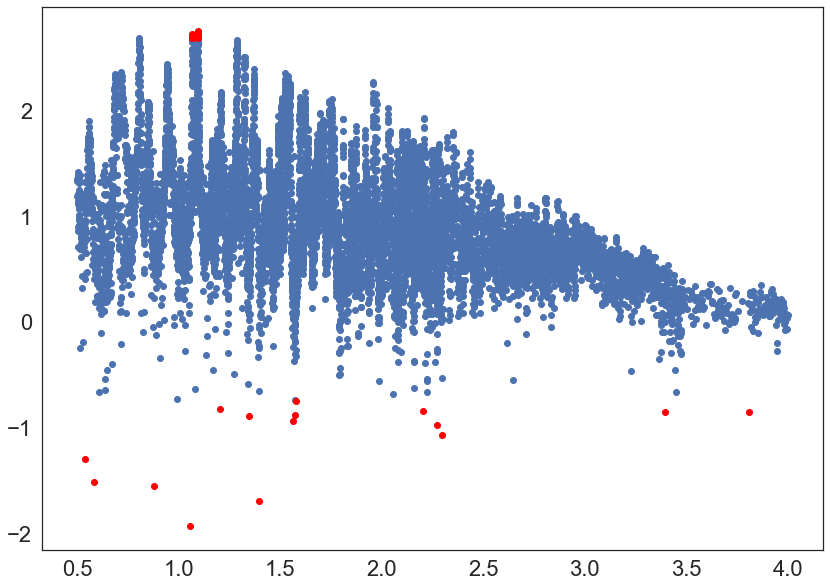

In [127]:
plt.figure(figsize=(14,10))
plt.scatter(svm_class1.Energy, svm_class1.Data)
plt.scatter(svm_class2.Energy, svm_class2.Data, color="red")

In [128]:
from sklearn.neighbors import LocalOutlierFactor

In [129]:
local_outlier = LocalOutlierFactor(n_neighbors=500, contamination=0.005)

u235_ng["local"] = local_outlier.fit_predict(u235_ng[["Data"]])

local_class1 = u235_ng[u235_ng.local == 1]
local_class2 = u235_ng[u235_ng.local == -1]

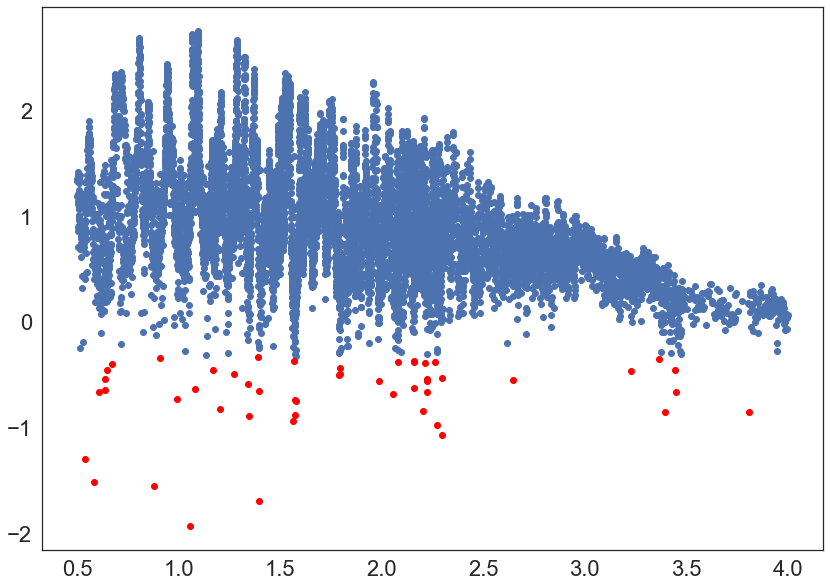

In [130]:
plt.figure(figsize=(14,10))
plt.scatter(local_class1.Energy, local_class1.Data)
plt.scatter(local_class2.Energy, local_class2.Data, color="red")

In [131]:
from sklearn.covariance import EllipticEnvelope

In [136]:
robust = EllipticEnvelope(contamination=outliers_fraction)

In [137]:
robust.fit(u235_ng[["Data"]])

EllipticEnvelope(contamination=0.003)

In [138]:
u235_ng["robust"] = robust.predict(u235_ng[["Data"]])

In [139]:
robust_class1 = u235_ng[u235_ng.svm == 1]
robust_class2 = u235_ng[u235_ng.svm == -1]

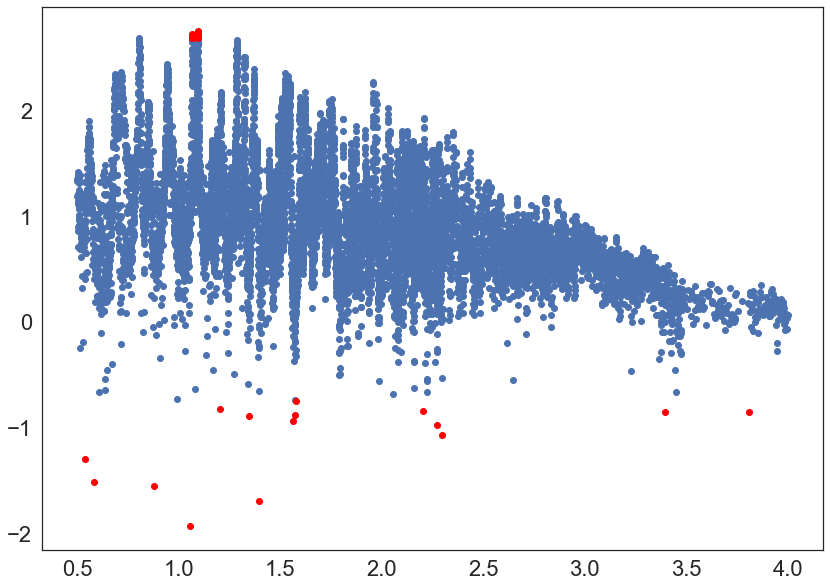

In [140]:
plt.figure(figsize=(14,10))
plt.scatter(robust_class1.Energy, robust_class1.Data)
plt.scatter(robust_class2.Energy, robust_class2.Data, color="red")

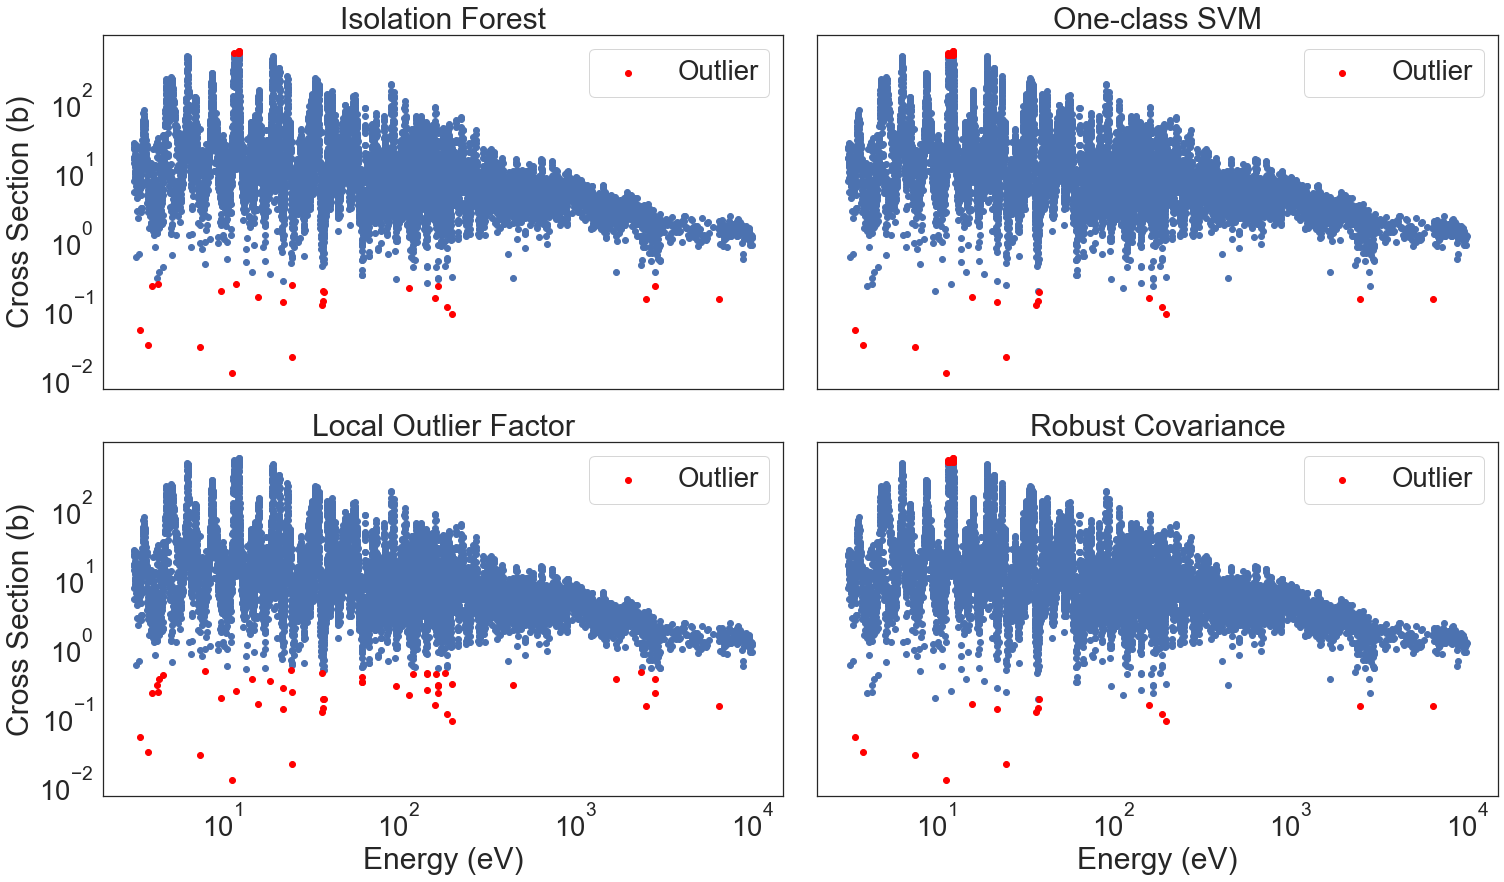

In [175]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25,14), gridspec_kw={'hspace': 0.15, 'wspace':0.05})

ax1.scatter(10**(iso_class1.Energy), 10**(iso_class1.Data))
ax1.scatter(10**(iso_class2.Energy), 10**(iso_class2.Data), color="red", label="Outlier")

ax2.scatter(10**(svm_class1.Energy), 10**(svm_class1.Data))
ax2.scatter(10**(svm_class2.Energy), 10**(svm_class2.Data), color="red", label="Outlier")

ax3.scatter(10**(local_class1.Energy), 10**(local_class1.Data))
ax3.scatter(10**(local_class2.Energy), 10**(local_class2.Data), color="red", label="Outlier")

ax4.scatter(10**(robust_class1.Energy), 10**(robust_class1.Data))
ax4.scatter(10**(robust_class2.Energy), 10**(robust_class2.Data), color="red", label="Outlier")

for i, t in zip([ax1, ax2, ax3, ax4], ["Isolation Forest", "One-class SVM", "Local Outlier Factor", "Robust Covariance"]):
    i.set_xlabel('Energy (eV)')
    i.set_ylabel('Cross Section (b)')
    i.set_xscale('log')
    i.set_yscale('log')
    i.set_title(t)
    i.legend()
    
for ax in fig.get_axes():
    ax.label_outer()
    
plt.savefig(os.path.join(figure_dir, "outlier_detection.png"), bbox_inches='tight', dpi=600)